In [ ]:
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pandas as pd
import cv2
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython.core.display import clear_output
!unzip '/content/drive/MyDrive/dataset.zip' -d 'dataset'
clear_output()

In [ ]:
df = pd.read_csv("/content/dataset/train.csv",low_memory = False)
# To display the top 5 rows
df.head(5)

,image,Class
0,00001.jpg,14
1,00002.jpg,3
2,00003.jpg,91
3,00004.jpg,134
4,00005.jpg,106


In [ ]:
class Dataset():
    def __init__(self, df, transform=None, target_transform=None):
        self.df = df
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = "/content/dataset/dataset/" + self.df.iloc[idx, 0]
        image = cv2.imread(path)
        label = self.df.iloc[idx, 1]-1 #reduce value of classes by 1 couse lables starts from 0 in dataset
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = torch.tensor(label)
        return image, label

In [ ]:
image_transforms = transforms.Compose([ transforms.ToTensor(),
                                        transforms.Resize((256, 256)),
                                        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                                      ])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Total: 7000


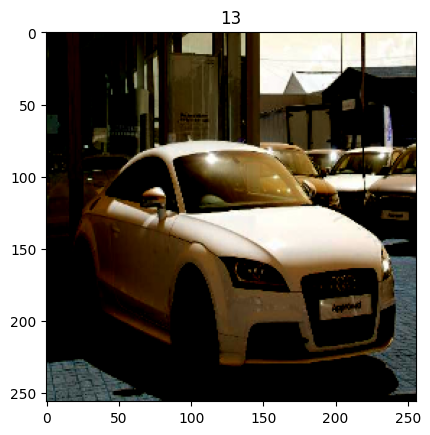

In [ ]:
dataset = Dataset(df = df, transform = image_transforms, target_transform = True)
# get len dataset
print(f'Total: {dataset.__len__()}')
# show 1th-image and label
img, label = dataset.__getitem__(0)

plt.imshow(img.permute(1, 2, 0))
plt.title(label.item())
plt.show()

In [ ]:
train_count = int(0.9*len(dataset))
test_count = len(dataset)-train_count
train_set, test_set = random_split(dataset, [train_count, test_count])

train_size = int(0.9*train_count)
val_size = train_count-train_size
train_set, val_set = random_split(train_set, [train_size, val_size])

print('dataset len: ', dataset.__len__())
print('train set: ', train_set.__len__())
print('val set: ', val_set.__len__())
print('test set: ', test_set.__len__())

dataset len:  7000
train set:  5670
val set:  630
test set:  700


In [ ]:
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
import torchvision.models as models
model = models.wide_resnet101_2(pretrained=True)
# for params in model.parameters():
#             params.requires_grad = True

model.to(device);

KeyboardInterrupt: ignored

In [ ]:
! pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchinfo import summary
summary(model,input_size=(1, 3, 244, 244))

/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 122, 122]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 122, 122]         (128)
├─ReLU: 1-3                              [1, 64, 122, 122]         --
├─MaxPool2d: 1-4                         [1, 64, 61, 61]           --
├─Sequential: 1-5                        [1, 256, 61, 61]          --
│    └─Bottleneck: 2-1                   [1, 256, 61, 61]          --
│    │    └─Conv2d: 3-1                  [1, 128, 61, 61]          (8,192)
│    │    └─BatchNorm2d: 3-2             [1, 128, 61, 61]          (256)
│    │    └─ReLU: 3-3                    [1, 128, 61, 61]          --
│    │    └─Conv2d: 3-4                  [1, 128, 61, 61]          (147,456)
│    │    └─BatchNorm2d: 3-5             [1, 128, 61, 61]          (256)
│    │    └─ReLU: 3-6                    [1, 128, 61, 61]  

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [ ]:
model.fc = nn.Linear(2048, 196)
# print(model.classifier[6])
summary(model,input_size=(1, 3, 232, 232))

/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 196]                  --
├─Conv2d: 1-1                            [1, 64, 116, 116]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 116, 116]         (128)
├─ReLU: 1-3                              [1, 64, 116, 116]         --
├─MaxPool2d: 1-4                         [1, 64, 58, 58]           --
├─Sequential: 1-5                        [1, 256, 58, 58]          --
│    └─Bottleneck: 2-1                   [1, 256, 58, 58]          --
│    │    └─Conv2d: 3-1                  [1, 128, 58, 58]          (8,192)
│    │    └─BatchNorm2d: 3-2             [1, 128, 58, 58]          (256)
│    │    └─ReLU: 3-3                    [1, 128, 58, 58]          --
│    │    └─Conv2d: 3-4                  [1, 128, 58, 58]          (147,456)
│    │    └─BatchNorm2d: 3-5             [1, 128, 58, 58]          (256)
│    │    └─ReLU: 3-6                    [1, 128, 58, 58]  

In [ ]:
from torch import optim
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_losses=[]
train_acc=[]
def train(model,epoch):
    print('\nEpoch : %d'%epoch)
    model.train()
    running_loss=0
    correct=0
    total=0
    for data in tqdm(train_loader):
        inputs,labels=data[0].to(device),data[1].to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        labels = labels.squeeze()
        optimizer.zero_grad()
        outputs=model(inputs)
        outputs.squeeze
        loss=loss_fn(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_loss=running_loss/len(train_loader)
    acc=100.*correct/total
    train_acc.append(acc)
    train_losses.append(train_loss)
    print('Train Loss per epoch: %.4f | Train Accuracy per epoch: %.4f'%(train_loss,acc))

In [ ]:
val_losses=[]
val_acc=[]
def test(model,epoch):
    print('\nEpoch : %d'%epoch)
    model.eval()
    running_loss=0
    correct=0
    total=0
    with torch.no_grad():
        for data in tqdm(test_loader):

            inputs,labels=data[0].to(device),data[1].to(device)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            labels = labels.squeeze()
            outputs=model(inputs)
            outputs.squeeze
            loss=loss_fn(outputs,labels)

            running_loss += loss.item()

            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        val_loss=running_loss/len(train_loader)
        acc=100.*correct/total
        val_acc.append(acc)
        val_losses.append(val_loss)
        print('Val Loss per epoch: %.4f | Val Accuracy per epoch: %.4f'%(val_loss,acc))

In [ ]:
max_epochs=10
for epoch in range(1,max_epochs+1):
    train(model,epoch)
    test(model,epoch)


Epoch : 1


  0%|          | 0/89 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  1%|          | 1/89 [01:31<2:14:40, 91.82s/it]

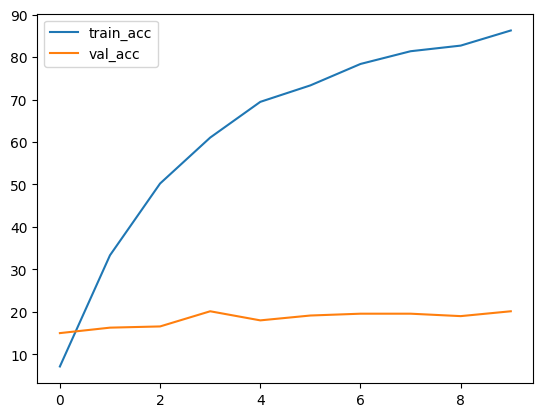

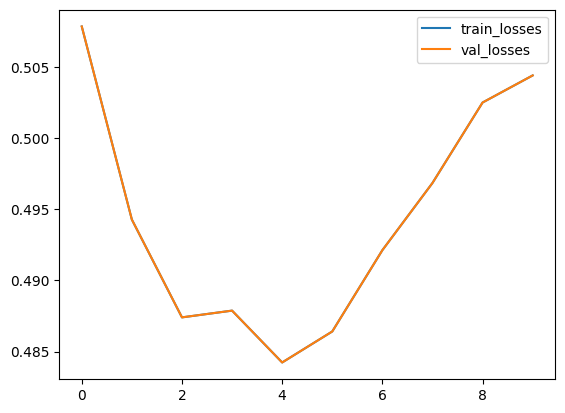

In [ ]:
plt.plot(train_acc,label = "train_acc")
plt.plot(val_acc,label = "val_acc")
plt.legend()
plt.show()

plt.plot(val_losses,label = "train_losses")
plt.plot(val_losses,label = "val_losses")
plt.legend()
plt.show()

In [ ]:
model_scripted = torch.jit.script(model)
model_scripted.save('model_scripted.pt')